# Importando os Dados
Importando dados do Google Drive para o ambiente do Colab.

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_reviews_dataset.csv

In [1]:
# Montando o Google Drive no Colab
from google.colab import drive
drive.mount('/content/gdrive')

# Definindo o caminho para o diretório dos dados
data_dir = '/content/gdrive/My Drive/Colab Notebooks/sentiment/data/olist_order_reviews_dataset.csv'

import pandas as pd

# Carregando o dataset
df = pd.read_csv(data_dir)

# Exibindo as primeiras linhas do dataset para entender sua estrutura
df = df[['review_comment_message', 'review_score']]
df.head()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,review_comment_message,review_score
0,NaN,4
1,NaN,5
2,NaN,5
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5


# Pré-processamento de Dados

Primeiro, os dados serão preparados para o modelo. Isso inclui lidar com valores nulos, tokenização e padronização do tamanho dos textos.

### Limpeza de Dados

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Preencha valores NaN com uma string vazia
df['review_comment_message'].fillna('', inplace=True)

### Tokenização

Conversão dos textos em sequências de números, onde cada número representa uma palavra no dicionário.

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review_comment_message'])
sequences = tokenizer.texts_to_sequences(df['review_comment_message'])


### Padronização

Padronização do comprimento das sequências para que todas tenham o mesmo tamanho.

In [4]:
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length, padding='post')


# Preparação do Target

Transformação dos scores de revisão em categorias de sentimentos. Por exemplo, scores 4 e 5 como positivos, 3 como neutros e 1 e 2 como negativos.

In [5]:
def categorize(score):
    if score < 3:
        return 0  # Negativo
    elif score == 3:
        return 1  # Neutro
    else:
        return 2  # Positivo

y = df['review_score'].apply(categorize)


# Construção do Modelo

Utilização do Keras para construir o modelo de RNN do tipo LSTM.

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

vocab_size = len(tokenizer.word_index) + 1  # Tamanho do vocabulário

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 classes: Negativo, Neutro, Positivo

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Treinamento do Modelo

Divisão dos dados em conjuntos de treinamento e teste.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=3,
    batch_size=64
)


Epoch 1/3
1241/1241 [==============================] - 185s 141ms/step - loss: 0.5706 - accuracy: 0.8077 - val_loss: 0.6032 - val_accuracy: 0.7658
Epoch 2/3
1241/1241 [==============================] - 169s 136ms/step - loss: 0.5588 - accuracy: 0.8238 - val_loss: 0.5493 - val_accuracy: 0.8252
Epoch 3/3
1241/1241 [==============================] - 168s 136ms/step - loss: 0.5552 - accuracy: 0.8124 - val_loss: 0.5611 - val_accuracy: 0.8124


# Avaliação do Modelo

Avaliação do modelo no conjunto de teste.[texto do link](https://)

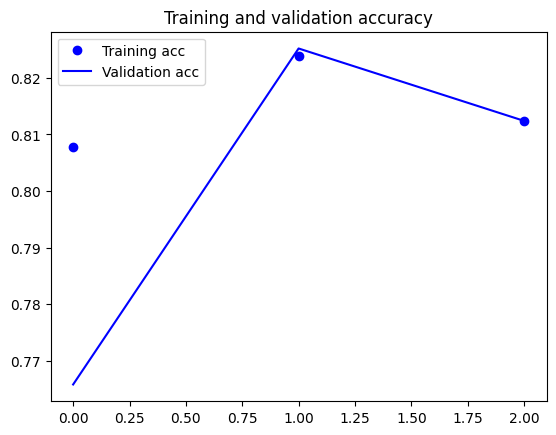

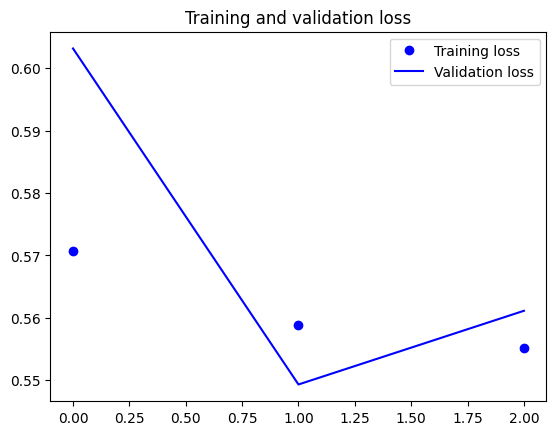

In [10]:
import matplotlib.pyplot as plt

# Plota os resultados do treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

A análise das métricas `loss` e `val_loss` durante o treinamento de um modelo de aprendizado de máquina é crucial para entender o desempenho e identificar áreas para melhoria. No caso do presente exercício, as métricas indicam como o modelo está aprendendo e generalizando para dados não vistos. Vamos analisar os valores e discutir possíveis melhorias:

### Análise das Métricas
- **`loss` (Erro no Treinamento)**: [0.5706, 0.5588, 0.5551]
- **`val_loss` (Erro na Validação)**: [0.6031, 0.5492, 0.5611]

#### Observações:
1. **Redução do Erro de Treinamento**: O `loss` está diminuindo ao longo das épocas, o que é um bom sinal. Isso indica que o modelo está aprendendo com os dados de treinamento.
2. **Flutuação do Erro de Validação**: O `val_loss` inicialmente diminui e depois aumenta ligeiramente. Isso pode indicar um início de sobreajuste ou uma variação normal devido ao tamanho do conjunto de validação.

### Estratégias de Melhoria

#### 1. Ajuste dos Hiperparâmetros
- **Número de Neurônios LSTM**: Aumentar o número de neurônios na camada LSTM. Um número maior pode capturar melhor a complexidade dos dados.
- **Taxa de Dropout**: Ajustar as taxas de dropout. Às vezes, uma taxa mais alta ou mais baixa pode ajudar a prevenir o sobreajuste.
- **Taxa de Aprendizagem**: Ajustar a taxa de aprendizagem do otimizador Adam. Uma taxa de aprendizagem menor pode levar a uma convergência mais estável.

#### 2. Regularização
- **Early Stopping**: Usar Early Stopping para interromper o treinamento assim que o `val_loss` começar a aumentar, evitando sobreajuste.
- **Regularização L1/L2**: Aplicar regularização L1 ou L2 nas camadas para controlar a complexidade do modelo.

#### 3. Alterações na Arquitetura
- **Camadas Adicionais**: Experimentar adicionar mais camadas LSTM ou camadas densas.
- **Bidirecional LSTM**: Usar LSTM bidirecional para capturar padrões em ambas as direções dos dados de texto.

#### 4. Pré-processamento e Engenharia de Recursos
- **Embeddings Pré-treinados**: Em vez de usar Embeddings aleatórios, pode ser interessante usar embeddings pré-treinados como Word2Vec ou GloVe.
- **Limpeza de Dados**: Certificar de que os dados de texto estão limpos e pré-processados de forma adequada (remoção de stopwords, lematização, etc.).

#### 5. Ajuste Fino e Experimentação
- **Validação Cruzada**: Usar validação cruzada para obter uma estimativa mais robusta do desempenho do modelo.
- **Experimentação Iterativa**: Modelos de aprendizado profundo muitas vezes requer experimentação iterativa. Testar diferentes combinações das estratégias acima pode ser interessante.